# Project: Investigating No-Show Appointments

## Table of Contents
<ul>
    <li><a href='#intro'>Introduction</a></li>
    <li><a href='#dataWrangling'>Data Wrangling</a></li>
    <li><a href='#dataExplore'>Exploratory Data Analysis</a></li>
    <li><a href='#conclusion'>Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
>In this analysis, data for over 110,000 Brazilian medical appointment records are analyzed.  This analysis focuses on assessing rate of 'Show' and 'No-Show' given a number of diferent variables

In [2]:
#import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


#create dataframe from csv
df = pd.read_csv('noshowAppointments.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<a id='dataWrangling'></a>
# Data Wrangling

## Data Summary

The dataframe consist of 14 columns and 110,527 rows.  That dataframe consist of three different data types: float64, int64 and object (string). 

### Column notes
<ul>
    <li>ScheduledDay = date the appointment was set up</li>
    <li>AppointmentDay = date of the appointment</li>
    <li>Scholarship = is the client enrolled in federal assistance program 'Bolsa Familia'</li>
    <li>No-show = 'No' means they showed up, 'yes' means they did not show up</li>
    <li>Handcap = Per Kaggle data author, this represents the number of impairments the client suffers from</li>
</ul>

## General Properties

### Nulls
The below code checks for rows with null values. 0 items are found.

In [3]:
df.isnull().sum()




PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

### Duplicates
The below code looks for exact duplicate rows. 0 duplicate rows are found. Looking to patient ID's, there are a total of 48,228 duplicated patient IDs.

In [4]:
dupRows = sum(df.duplicated())
dupClientID = sum(df['PatientId'].duplicated())
print('There are {} duplicated rows, and {} duplicated patient IDs'.format(dupRows,dupClientID))


There are 0 duplicated rows, and 48228 duplicated patient IDs


### Data Types
An earlier review of the data types for each column showed both 'ScheduledDay' and 'AppointmentDay' as obj (string), and thus both need to be converated into dates to support analysis.

### Data Integrity 
The below code provides a high level review of all columns that are numberic. The analysis shows some issues with the underlying data.

In [5]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


><strong>Data Integrity Results</strong>
<br/>
>Age: Ranges from -1 to 115. The negative values for age are incorrect.  Additionally, the value of 115 is exceptionally high and is also likely a data error.

## Data Cleaning
As previously mentioned, there were two data issues noted: Dates stored as strings, and the range of age values. 

In [6]:
#dates are stored as strings, need to convert to proper dates to do calc's later
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

>In the above code, columns containing date type data were converted from obj (string) to dates. 

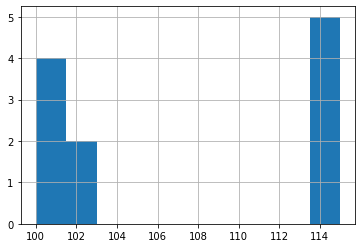

In [7]:
# replace age of -1 with avg. age
df.loc[df['Age']==-1, 'Age'] = df['Age'].mean()

# Review records with age 100 or greater.
df.query('Age >= 100')['Age'].hist();

> <strong>Negative Age: </strong>In the above code, we updated the value of 'Age' to the mean of the 'Age' if it had a value of -1. 

> <strong>Age greater than 100: </strong>There were a higher than expected number of records with an 'Age' greater than or equal to 100 given the 2019 average life expectancy of 76 years according to macrotrends.net.  Lastly, according to UN data for 2018, Brazil sported 12.5 centenarians per 100,000 people. Given this information, we would expect roughly 6 centenarians in the dataset under analysis (an estimated 48,228 unique individuals), however, a close inspection reveals that there are 11 individuals listed as over 100.  To control for this, we'll be organizing age into bins and conduct analysis on the bin level.

## Data Preparation
Below, steps are taken to organize data into groups as well as conduct simple calulations. 


In [20]:
#add a date diff column
df['daysToAppointment'] =(df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Create bin edges using range analysis from df.describe()
binEdges = [-7,0,3,14,178]
binNames = ['Negative','Low','Medium','High']

#create new column with daystoAppointment bins
df['DaysToAptRange'] = pd.cut(df['daysToAppointment'],binEdges, labels = binNames)



In the above code we:
<ul>
    <li>Calculate days between schedule date and appointment date and assing to new column ['daysToAppointment']</li>
    <li>Create bin ranges and labeles based on quartile analysis</li>
    <li>Create new column ['DaysToAptRange'] and assigned based on calculated days.
</ul>

In [21]:
#Create bins for 'Age' to review relationship between age rate of 'no-show'
df['Age'].describe()

#modified bin range from outbput of 'describe' to better align with traditional age bins
ageBinEdges = [0,18,37,65,115]
ageBinNames = ['Young','Adult','Midle-Age','Senior']

#create new column
df['AgeRange'] = pd.cut(df['Age'], ageBinEdges, labels = ageBinNames)

In the above code we:
<ul>
    <li>Create bin ranges and labeles for age based on traditional age ranges</li>
    <li>Create new column ['AgeRange'] and assigned rows based on age.
</ul>

<a id='dataExplore'></a>
# Exploratory Data Analysis

### Baseline 
As the driving purpose of this analysis centers on the potential relationship between different variables on rate of 'No-Show' it is important to first get an understanding of the general rate of 'No-show' for the dataset. From here, we can than review what variables are associated with higher or lower rates of 'No-show' compared to the overall sample set.

Baseline appointment show rate 79.81%. Baseline no-show rate 20.19%


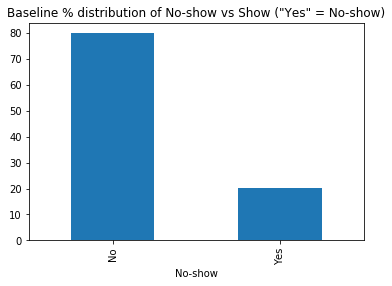

In [84]:
#First get baseline distribution of show vs no-shows
#totalRecordCount = df.shape[0]
#df['No-show'].value_counts()/round(totalRecordCount
#(d,2)f['No-show'].value_counts()/totalRecordCount*100).plot(kind='bar', title ='Baseline % distribution of No-show vs Show ("Yes" = No-show)');
df1 = df.groupby('No-show')['AppointmentID'].count()
df1 = df1.divide(df1.sum())*100
clientNoShow = round(df1[0],2).astype(str)
clientShow = round(df1[1],2).astype(str)
print('Baseline appointment show rate ' + clientNoShow + '%. Baseline no-show rate '+ clientShow +'%');
df1.plot(kind='bar', title ='Baseline % distribution of No-show vs Show ("Yes" = No-show)');



> <strong>Baseline analysis: </strong> A quick review of the dataset shows roughly 80% of individuals show up for their appointment, while about 20% are no-shows. We'll be reviewing the dataset to see if we can find variables that correlate with a no-show rate that is meaningfully higher or lower from the baseline rate of 20%.

### Q1. Do clients with medical coverage have lower no show?


Rate of no-show for clients with scholarship: 19.81% Rate of no-show for clients without scholarship:23.74%


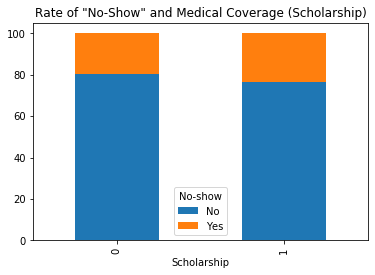

In [85]:
#Does medical coverage correlate with show vs no-show
# Create simple stacked barchart to compare rate of 'no-show'
df2 = df.groupby(['Scholarship','No-show'])['AppointmentID'].count().unstack()
df2 = df2.T.div(df2.T.sum()).T*100
df2.plot(kind='bar',stacked=True, title = 'Rate of "No-Show" and Medical Coverage (Scholarship)');
noshowNoScholarship = round(df2.unstack().T[2],2).astype(str)
noshowYesScholarhip = round(df2.unstack().T[3],2).astype(str)
print('% Rate of no-show for clients with scholarship: ' + str(noshowNoScholarship) + '% Rate of no-show for clients without scholarship:' + str(noshowYesScholarhip) + '%')


> <strong>Scholarship Analysis: </strong>Based on the above analysis, it does not look like there exists a strong relationship between medical coverage (Scholarship) and rate of 'no-show'. For both individuals with and without scholarship, the rate of 'no-show' stands at around 20%--the same as the baseline. 

### Q2. Does length in time between appointment schedule date and appointment date impact no-show?


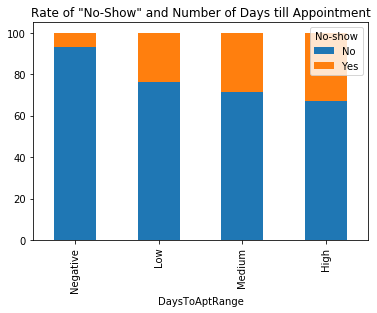

In [86]:
#Create new dataframe to focus on DaysToAptRange and no show
df3 = df.groupby(['DaysToAptRange','No-show'])['AppointmentID'].count().unstack()

# with new dateframe, divide and manipulate to create simple barchart
df3.T.div(df3.T.sum()/100).T.plot(kind='bar',stacked=True, title='Rate of "No-Show" and Number of Days till Appointment');

> <strong>Days from appointment schedule date to appointment date Analysis: </strong> Based on the visualization above, there is a clear positive correlation between the length of time between dates and 'no-show'. As the number of days from date of appointment scheduled to date of appointment increases, the rate of no-show tends to increase.  

### Q3. Do recieved SMS messages correlate with lower/higher no-show?

No-show rate for SMS received: 27.57%, no-show rate for no SMS recieved 16.7%


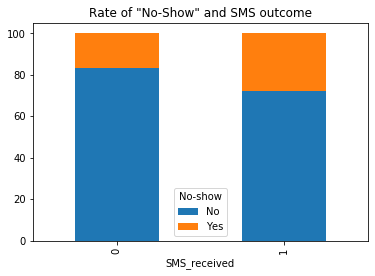

In [117]:
#Create new dataframe based on group by sms and no-show
df4 = df.groupby(['SMS_received','No-show'])['AppointmentID'].count().unstack()

#plot stacked bar chart
df4 = df4.T.divide(df4.T.sum()/100).T
noShowSMSReceived = round(df4.unstack().T[3],2).astype(str)
noShowSMSNoReceived = round(df4.unstack().T[2],2).astype(str)

print('No-show rate for SMS received: ' + noShowSMSReceived + '%, no-show rate for no SMS recieved ' + noShowSMSNoReceived + '%')
df4.plot(kind='bar',stacked = True, title = 'Rate of "No-Show" and SMS outcome');

> <strong>SMS and no-show analysis: </strong>The above visual goes counter to what one would expect, it shows a positive correlation between SMS messages and rate of no-show.  Individuals who recieve a SMS have a higher rate of no-show compared to patients who did not recieve a SMS. 

### Q4. Do individuals with a handicap have a lower no-show rate?

In the below code a new calculated field 'hasHandicap', which is set as 0 (false, ie no handicap) by default. Afterwards, if the client has any impairment (handcap >=1), then 'hasHandicap' is set to 1.  This is used to view broadly any potential correlation between a client having any impairment and rate of no-show 

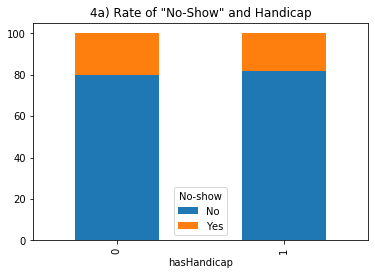

In [88]:
#does Handcap impact show vs no-show?
df5 = df

#create new column, default to false (0)
df5['hasHandicap'] = 0

# set hasHandicap = 1 if patient has 1 or more 'Handcap'
df5.loc[df['Handcap'] >= 1, 'hasHandicap'] = 1

# create stacked bar chart
df5 = df5.groupby(['hasHandicap','No-show'])['AppointmentID'].count().unstack()
df5.T.divide(df5.T.sum()/100).T.plot(kind='bar', stacked=True, title='4a) Rate of "No-Show" and Handicap');

#### A deeper review on handicap data and no-show

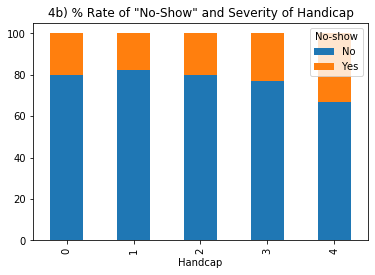

In [91]:
#Instead of looking at aggregate handicap data, we'll review all values of 'Handcap'  1 to 4
df5 = df.groupby(['Handcap','No-show'])['AppointmentID'].count().unstack()
df5.T.divide(df5.T.sum()/100).T.plot(kind='bar', stacked=True, title='4b) % Rate of "No-Show" and Severity of Handicap');


> <strong>Existance of Handicap and No-show analysis: </strong>Based on visual 4a the rate of 'no-show' is roughly the same for both individuals with and without a handicap when viewing in aggregate. When reviewing more detailed 'Handcap' data, as seen in 4b, there does appear to be an increase in the rate of 'No-show' as the number of 'Handcap' increases.

### Q5. Do older individuals stick with their appointments?

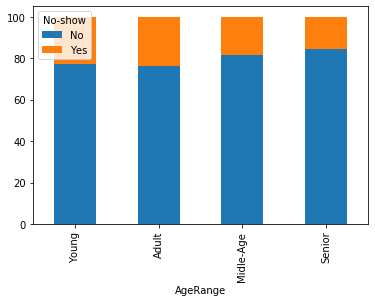

In [92]:
# Create new dataframe, grouping by age range and no-show
df6 = df.groupby(['AgeRange','No-show'])['AppointmentID'].count().unstack()
df6.T.divide(df6.T.sum()/100).T.plot(kind = 'bar', stacked = True);

> <strong>Age and No-show analysis: </strong>Based on the above visual there is a mild correlation between age and rate of no-show. The visual demonstrates that younger individuals tend to have higher rates of no-show (no-show = 'Yes') as compared to older individuals. Seniors (65+) demonstrated the lowest rate of missing appointments compared to other age groups. 

### Q6. Investigating SMS and length of time to appointment and no-show

Previously it was noted that SMS_Recieved and higher lengths of times between scheduled date and appointment date were associated with a higher no-show rate. The below analysis visualizes the observed rate of no-show in relation to both SMS_Recieved and length of time between scheduled date and appointment date.
<br/>
<strong>For both of the below visuals, we exclude negative items for 'DaysToAptRange'</strong>

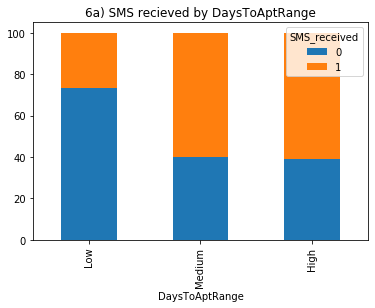

In [93]:
#Review potential correlation between DaysToAptRange and SMS_received
df7 = df.query('DaysToAptRange != "Negative"').groupby(['DaysToAptRange','SMS_received'])['AppointmentID'].count().unstack()
df7.T.divide(df7.T.sum()/100).T.plot(kind='bar', stacked = True, title='6a) % SMS recieved by DaysToAptRange');


Based on the above analysis, it appears that a higher 'DaysToAptRange' is associated with greater rate of SMS_recieved. With this in mind, the below then attempts to visualize rate of no-show against DaysToAptRange and SMS_Recieved.

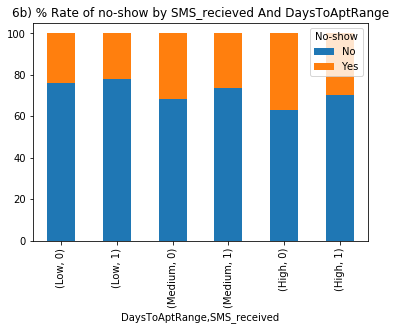

In [94]:
df8 = df.query('DaysToAptRange != "Negative"').groupby(['DaysToAptRange','SMS_received','No-show'])['AppointmentID'].count().unstack()
df8.T.divide(df8.T.sum()/100).T.plot(kind='bar',stacked = True, title ='6b) % Rate of no-show by SMS_recieved And DaysToAptRange');

><strong>Analysis of rate of no-show and SMS_Recieved and DaysToAptRange</strong>In the above analysis, visual 6b demonstrates that SMS_Recieved correlates positively with decreased rates of no-show after factoring the impact of DaysToAptRange.  Within each category, the rate of no-show equal to 'Yes' decreased when a SMS message was recieved.  This suggest that a text reminder correlates with a higher rate of clients showing up to their appointments.

<a id='conclusion'></a>
## Conclusions

The above analysis visually reviews the possible relationship between different variables and the rate of no-show for the purpose of finding a variable or combination of variables that significantly impact the rate of no-show. For the dataset as a whole the rate of no-show = 'Yes' stood at roughly 20%, while 80% of appointments were succesful with the client showing up. 

For the majority of variables in the dataset, there appears to be no or weak correlation with rate of no-show. For example, in Q1 (Do clients with medical coverage have lower no show?) the dataset was split by the variable 'Scholarship'.  Based on the chart, the rate of no-show for patients with and without scholarship was roughly the same at 19.8% for clients without scholarship and 23.7% for clients with scholarship.


In Q2 (Does length in time between appointment schedule date and appointment date impact no-show?), the rate of no-show was analyzed against the length of time between the date an appointment was scheduled and the actual date of the appointment.  To better visualize and assess the relationship between rate of no-show and length of time between 'ScheduledDay' and 'AppointmentDay', a new column--DaysToAptRange--was created fitting the date difference between 'ScheduledDay' and 'AppointmentDay' into a bin. As shown on the chart, there was clear increase in no-show rate as length of days increases between 'ScheduledDay' and 'AppointmentDay'.


In Q3 (Do recieved SMS messages correlate with lower/higher no-show?), the dataset is split on the variable 'SMS_recieved' tom cpare the rate of no-show for individuals who recieved a reminder sms message and those who did not. Surprisingly, a stacked bar chart showed that rate of no-show for patients who recieved a SMS message stood at 27.6%, while patients who did not recieve a SMS message had a no-show rate of 16.7%.  


Following the results of Q3, additional review of SMS_Recieved was warranted as the results were counter to initial expectations. The first step was to assess the potential correlation between SMS_Recieved and a seperate independent variable. Analysis reviewed a postive correlation between SMS_Recieved and DaysToAptRange. Namely, the occurance of SMS_Recieved increased as the measure of DaysToAptRange increased.  When the DaysToAptRange was 'Low', the occurance of SMS_Recieved stood at around 23% compared to rates of roughly 60% for DaysToAptRange within the ranges of 'Medium' and 'High' as shown in chart 4a.  This positive correlation offers insights into the results of Q3, and suggest that the increase of no-show rates seen in the patients who recieved a SMS message was simply related to the fact that most patients who recieved a SMS message were also patients who scheduled their appointments relatively far in advance.  With this in mind, the second part of Q4 focuses on analyzing rate of no-show with the variables of SMS_Recieved and DaysToAptRange. As the visual in 4b shows, the rate of no-show decreases for patients who recieved a SMS message compared to clients who did not recieve a SMS message after spliting the data by DaysToAptRange. 